In [1]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

/home/ubuntu/anaconda/envs/py36-venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load dataset and parse inputs

The English-French dataset: http://www.manythings.org/anki/fra-eng.zip

In [2]:
with open('data/fra.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [3]:
# Create empty vectors.
input_texts = [] # all input English sequences
target_texts = [] # all output French sequences
input_characters = set() # Keep the unique English characters in Input Sequence
target_characters = set() # Keep the unique French characters in Output Sequence

# Choose only the first 10,000 lines
num_samples = 10000

for line in lines[: min(num_samples, len(lines) - 1)]:
    # Parse the English and French sequences from lines
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    
    # Store sequences in vectors
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    # Store the unique characters
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

## Data Analysis

In [4]:
# Sort the unique English and French characters
input_characters = sorted(list(input_characters))
print("Unique English Characters:\n {}".format(input_characters))
target_characters = sorted(list(target_characters))
print("Unique French Characters:\n {}".format(target_characters))

# The length of unique English characters
num_encoder_tokens = len(input_characters)
print("Number of Unique English Characters:\n {}".format(num_encoder_tokens))
# The length of unique French characters
num_decoder_tokens = len(target_characters)
print("Number of Unique French Characters:\n {}".format(num_decoder_tokens))

# The length of max English sequence
max_encoder_seq_length = max([len(txt) for txt in input_texts])
print("The max length of English sequence: {}".format(max_encoder_seq_length))

# The length of max English sequence
max_decoder_seq_length = max([len(txt) for txt in target_texts])
print("The max length of French sequence: {}".format(max_decoder_seq_length))

Unique English Characters:
 [' ', '!', '$', '%', '&', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Unique French Characters:
 ['\t', '\n', ' ', '!', '$', '%', '&', "'", '(', ')', ',', '-', '.', '0', '1', '3', '5', '6', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '«', '»', 'À', 'Ç', 'É', 'Ê', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ', '\u2009', '’', '\u202f']
Number of Unique English Characters:
 71
Number of Unique French Characters:
 94
The max length of Engl

# Vectorization

## Build Dictionaries for English and French Characters

In [5]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)]
)
print("English character and index dictioary:\n {}".format(input_token_index))

target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)]
)
print("French character and index dictioary:\n {}".format(target_token_index))

English character and index dictioary:
 {' ': 0, '!': 1, '$': 2, '%': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '6': 15, '7': 16, '8': 17, '9': 18, ':': 19, '?': 20, 'A': 21, 'B': 22, 'C': 23, 'D': 24, 'E': 25, 'F': 26, 'G': 27, 'H': 28, 'I': 29, 'J': 30, 'K': 31, 'L': 32, 'M': 33, 'N': 34, 'O': 35, 'P': 36, 'Q': 37, 'R': 38, 'S': 39, 'T': 40, 'U': 41, 'V': 42, 'W': 43, 'Y': 44, 'a': 45, 'b': 46, 'c': 47, 'd': 48, 'e': 49, 'f': 50, 'g': 51, 'h': 52, 'i': 53, 'j': 54, 'k': 55, 'l': 56, 'm': 57, 'n': 58, 'o': 59, 'p': 60, 'q': 61, 'r': 62, 's': 63, 't': 64, 'u': 65, 'v': 66, 'w': 67, 'x': 68, 'y': 69, 'z': 70}
French character and index dictioary:
 {'\t': 0, '\n': 1, ' ': 2, '!': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, ',': 10, '-': 11, '.': 12, '0': 13, '1': 14, '3': 15, '5': 16, '6': 17, '8': 18, '9': 19, ':': 20, '?': 21, 'A': 22, 'B': 23, 'C': 24, 'D': 25, 'E': 26, 'F': 27, 'G': 28, 'H': 29, 'I': 30, 'J': 31, 'K': 32, '

## Initialize tensors for model inputs and targets

In [6]:
# English sentence
encoder_input_data = np.zeros(
    (len(input_texts), 
     max_encoder_seq_length, 
     num_encoder_tokens),
    dtype='float32'
)

# Encoder internal states
decoder_input_data = np.zeros(
    (len(input_texts), 
     max_decoder_seq_length, 
     num_decoder_tokens),
    dtype='float32'
)
# French sentence
decoder_target_data = np.zeros(
    (len(input_texts), 
     max_decoder_seq_length, 
     num_decoder_tokens),
    dtype='float32'
)

## One-hot Encoding for inputs and target dataset

In [7]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    # i is the index of a line (English and French pair)
    # t is the index of char in a sentence, and represents the time step
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    
    for t, char in enumerate(target_text):
        
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep, and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
            

## Training Mode: Construct the Encoder-Decoder Neural Network by Keras Functional API

The units in LSTM layers represent the latent dimensions.

The number of units in Encoder layer is the same as the number of units in Decoder layer.

## Encoder LSTM Layer

In [8]:
num_units = 256

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_outputs, state_h, state_c = LSTM(num_units, return_state=True)(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

## Decoder LSTM Layer

In [9]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(num_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [10]:
# Define the model that will turn `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [11]:
# Run training
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], 
          decoder_target_data,
          batch_size=64,
          epochs=100,
          validation_split=0.2
         )

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 20s 3ms/step - loss: 0.9672 - val_loss: 1.0267
Epoch 2/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.7649 - val_loss: 0.8263
Epoch 3/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.6475 - val_loss: 0.7347
Epoch 4/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.5878 - val_loss: 0.6831
Epoch 5/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.5492 - val_loss: 0.6570
Epoch 6/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.5219 - val_loss: 0.6246
Epoch 7/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.4999 - val_loss: 0.6043
Epoch 8/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.4798 - val_loss: 0.5877
Epoch 9/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.4633 - val_loss: 0.5678
Epoch 10/100
800

/home/ubuntu/anaconda/envs/py36-venv/lib/python3.6/site-packages/keras/engine/network.py:888: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


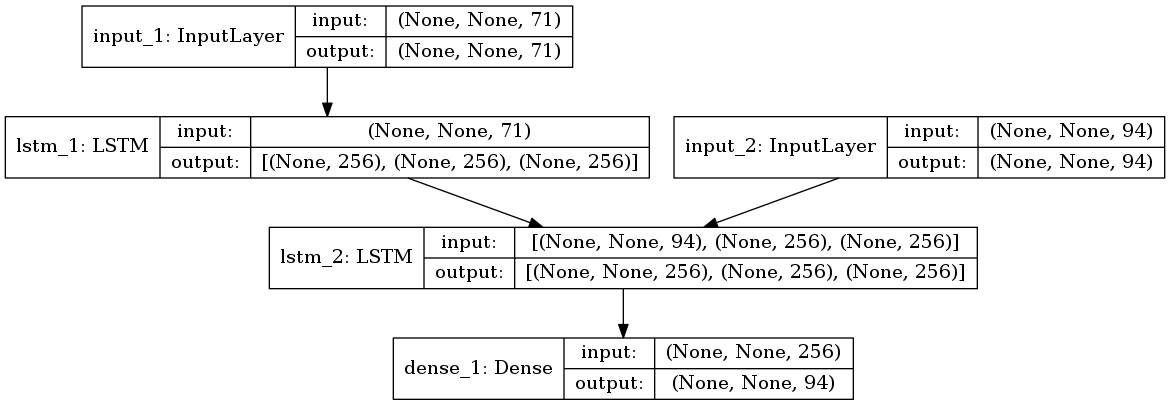

In [12]:
# plot and save the model
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file='models/s2s_arch.png', show_shapes=True)

model.save('models/s2s.h5')
Image('models/s2s_arch.png')

## Inference Mode: Apply Trained Model for Sequence Predictions
The model defined for training has learned weights for this operation, but the structure of the model is not designed 
to be called recursively to generate one character at a time.

Instead, new models are required for the prediction step, specifically a model for encoding English input sequences of characters and a model that takes the sequence of French characters generated so far and the encoding as input and predicts the next character in the sequence.

In [14]:
# Define the encoder inference model
inference_encoder_model = Model(encoder_inputs, encoder_states)

# Define the decoder inference model
decoder_state_input_h = Input(shape=(num_units,))
decoder_state_input_c = Input(shape=(num_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
# The internal states and output of decoder will be rejected in the next recursive call.
inference_decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

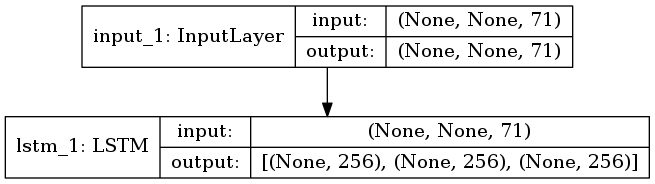

In [15]:
plot_model(inference_encoder_model, to_file='models/encoder_model.png', show_shapes=True)
plot_model(inference_decoder_model, to_file='models/decoder_model.png', show_shapes=True)

Image('models/encoder_model.png')


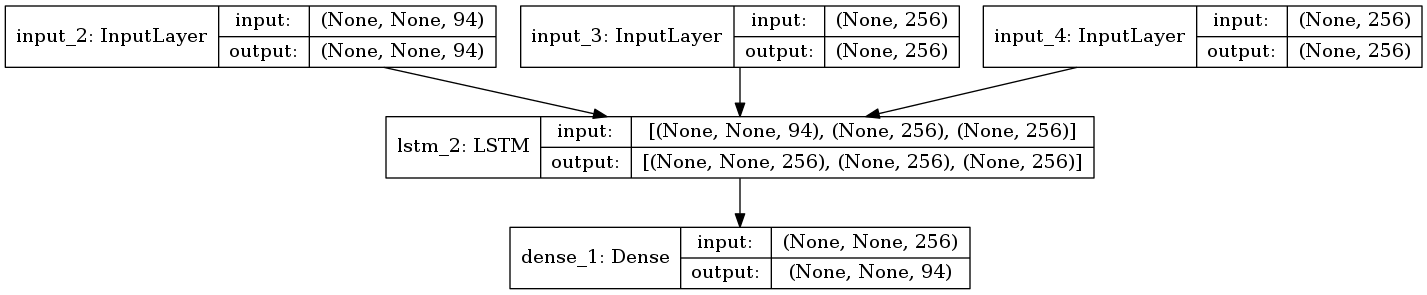

In [16]:
Image('models/decoder_model.png')

## Build a Reverse-lookup (index, token) dictionary to decode index back to char.

In [17]:
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items()
)

reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items()
)


## Translate an English sequence to French

In [18]:
def decode_sequence(input_seq):
    # Encode the input sequence as state vectors.
    states_value = inference_encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start Tab.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        
        output_tokens, h, c = inference_decoder_model.predict([target_seq] + states_value)

        # Predict the next char
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Lookup char based on index from dictionary
        sampled_char = reverse_target_char_index[sampled_token_index]
        # Append a new char in the output sentence
        decoded_sentence += sampled_char

        # Exit condition
        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [42]:
test_english_text = "Enjoy your day."
# Vectorize the test sequence.
vectorized_text = np.zeros(
    (1, max_encoder_seq_length, num_encoder_tokens),
    dtype='float32'
)
for t, char in enumerate(input_text):
    vectorized_text[0, t, input_token_index[char]] = 1.

print('Translated French sentence:', decode_sequence(vectorized_text))

Translated French sentence: Bonne journée à vous !

